![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [22]:
# Se identifican observaciones con valores nulos
data.isna().sum()

Price          0
Year           0
Mileage        0
M_Camry        0
M_Camry4dr     0
M_CamryBase    0
M_CamryL       0
M_CamryLE      0
M_CamrySE      0
M_CamryXLE     0
dtype: int64

In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
# Librerías utilizadas en los ejercicios
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
import xgboost as xgb

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
# Celda 1

# Definición de parámetros y criterios de parada
max_depth = 20

# Definimos la clase nodo para representar cada nodo del árbol
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold  #Valor límite para la división
        self.left = left  # Nodo izquierdo
        self.right = right  # Nodo derecho
        self.value = value  # Valor del nodo

# Definimos la clase DecisionTreeRegressor
class arbol_regresion:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def _mse(self, y):
        # Calculamos el MSE
        return np.mean((y - np.mean(y))**2)

    def _best_split(self, X, y):
        # Encontramos el mejor punto de corte basado en el que haya generado menor MSE
        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        for feature in X.columns:
            unique_values = X[feature].unique()
            for threshold in unique_values:
                left_indices = X[feature] <= threshold
                right_indices = ~left_indices

                mse_left = self._mse(y[left_indices])
                mse_right = self._mse(y[right_indices])

                mse = mse_left + mse_right

                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        # Crecimiento Recursivo del árbol
        if depth == self.max_depth or np.unique(y).size == 1:
            # Si se alcanza la máxima profundidad o cualquier parámetro de parada, crea un nodo hoja
            return Node(value=np.mean(y))

        feature, threshold = self._best_split(X, y)
        left_indices = X[feature] <= threshold
        right_indices = ~left_indices

        left = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature=feature, threshold=threshold, left=left, right=right)

    def fit(self, X, y):
        # Se ajusta el árbol de decisión a los datos de entrenamiento
        X = pd.DataFrame(X)
        y = pd.Series(y)
        self.root = self._build_tree(X, y, 0)

    def _predict_single(self, x, node):
        # Predecimos un sólo nodo de manera recursiva
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            # Nos enfocamos en lado izquierdo
            return self._predict_single(x, node.left)
        else:
            # Nos enfocamos en lado derecho
            return self._predict_single(x, node.right)

    def predict(self, X):
        # Predecimos valores objetivo para cada nodo
        X = pd.DataFrame(X)
        return np.array([self._predict_single(x, self.root) for _, x in X.iterrows()])

# Se crea el objeto
dt_regressor = arbol_regresion(max_depth=max_depth)

# ajustamos el modelo a los datos de entrenamiento
dt_regressor.fit(X_train, y_train)

# Para revisar el desempeño del modelo

# Se generan las predicciones para el conjunto de entrenamiento y prueba
y_train_pred = dt_regressor.predict(X_train)
y_test_pred = dt_regressor.predict(X_test)

# Se calcula el MSE, RMSE, MAE y R2 para el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Se calcula el MSE, RMSE, MAE y R2 para el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Se imprimen los resultados
print("Conjunto de entrenamiento:")
print("MSE:", mse_train)
print("RMSE:", rmse_train)
print("MAE:", mae_train)
print("R2:", r2_train)
print("")
print("Conjunto de prueba:")
print("MSE:", mse_test)
print("RMSE:", rmse_test)
print("MAE:", mae_test)
print("R2:", r2_test)

Conjunto de entrenamiento:
MSE: 6557926.03624679
RMSE: 2560.844789565894
MAE: 1947.6931752039877
R2: 0.5748336626676838

Conjunto de prueba:
MSE: 6809705.3146731015
RMSE: 2609.54120769784
MAE: 2000.8386167631988
R2: 0.5548090735320776


El árbol de regresión construido de manera manual presenta un RMSE de 2609.54 y un MAE de 2000.83 para predecir el precio en conjunto de Test.


| Punto  | Modelo                                  | RMSE     | MAE      |
|--------|-----------------------------------------|----------|----------|
|    1   | Arbol de regresión manual               | 2609.54  | 2000.83  |

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [7]:
# Celda 2

# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))

# Se agrupan los datos en train y test -  respetando la partición inicial
y_train_df = pd.DataFrame(y_train)
train = pd.concat([X_train, y_train_df], axis=1)

y_test_df = pd.DataFrame(y_test)
test = pd.concat([X_test, y_test_df], axis=1)

# Creación de 10 muestras de bootstrap 
np.random.seed(123)
n_samples = train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Construcción un árbol de decisión para cada muestra boostrap

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = train.iloc[sample, :-1]
    y_train = train.iloc[sample, -1]
    treereg.fit(X_train, y_train)
    y_pred.iloc[:,i] = treereg.predict(test.iloc[:, :-1])

# Desempeño de cada árbol
print("\n")

for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Arreglo: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Muestreo aleatorio:  [ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


Árbol  0 tiene un error:  2141.613353645869
Árbol  1 tiene un error:  2136.3519863123465
Árbol  2 tiene un error:  2122.718759132052
Árbol  3 tiene un error:  2087.278992468617
Árbol  4 tiene un error:  2168.518742842026
Árbol  5 tiene un error:  2113.8811455834793
Árbol  6 tiene un error:  2127.933470769012
Árbol  7 tiene un error:  2184.414847251443
Árbol  8 tiene un error:  2138.1071697514985
Árbol  9 tiene un error:  2132.097520859104


In [8]:
# Cálculo de MSE, RMSE, MAE y R2 para train y test

# Cálculo de predicciones promedio para cada observación del set de test
y_pred_mean = y_pred.mean(axis=1)

# Cálculo del desempeño en el conjunto de test
mse_test = mean_squared_error(y_test, y_pred_mean)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_mean)
r2_test = r2_score(y_test, y_pred_mean)

# Impresión de resultados
print('Resultados en conjunto de test:')
print('MSE: {:.3f}'.format(mse_test))
print('RMSE: {:.3f}'.format(rmse_test))
print('MAE: {:.3f}'.format(mae_test))
print('R2: {:.3f}'.format(r2_test))

Resultados en conjunto de test:
MSE: 3227180.818
RMSE: 1796.436
MAE: 1340.016
R2: 0.789


El modelo bagging construido de manera manual con 10 árboles de regresión presenta un RMSE de 1796.44 y un MAE de 1340.016 para predecir el precio en el conjunto de Test. Este modelo presenta una mejora importante frente al árbol de decisión de regresión construido en el punto anterior (RMSE de 2609.54 y un MAE de 2000.83).

| Punto  | Modelo                                  | RMSE     | MAE      |
|--------|-----------------------------------------|----------|----------|
|    1   | Arbol de regresión manual               | 2609.54  | 2000.83  |
|    2   | Bagging Manual                          | 1796.44  | 1340.01  |

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [9]:
# Definir el modelo
n_features = len(X_train.columns)
max_features = int(np.log(n_features))
bagreg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, max_features=max_features, bootstrap=True, oob_score=True, random_state=1)

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)

# Predicciones en train y test
y_train_pred = bagreg.predict(X_train)
y_test_pred = bagreg.predict(X_test)

# Calcular MSE, RMSE, MAE y r2 en train y test
# Train
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Test
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Imprimir resultados
print('\nResultados en conjunto de train:')
print("MSE train:", train_mse)
print("RMSE train:", train_rmse)
print("MAE train:", train_mae)
print("r2 train:", train_r2)

print('\nResultados en conjunto de test:')
print("MSE test:", test_mse)
print("RMSE test:", test_rmse)
print("MAE test:", test_mae)
print("r2 test:", test_r2)



Resultados en conjunto de train:
MSE train: 5746335.100616486
RMSE train: 2397.1514555022354
MAE train: 1869.0357915895122
r2 train: 0.6254426205239844

Resultados en conjunto de test:
MSE test: 7284044.142810102
RMSE test: 2698.896838119253
MAE test: 2106.931520947474
r2 test: 0.5237987239501358


El modelo bagging construido con ayuda de la librería sklearn, contemplando como parámetro 10 árboles de regresión y max_features = log(n_features), presenta un RMSE de 2698.89 y un MAE de 2106.93 para predecir el precio en el conjunto de Test. Este modelo no presenta una mejora importante frente al modelo de Baggin manual construido en el punto anterior (RMSE de 1796.44 y un MAE de 1340.01), lo que permite cuestionar si los parámetros entregados al algoritmo son los optimos para modelar el problema.


| Punto  | Modelo                    | RMSE     | MAE      |
|--------|---------------------------|----------|----------|
|    1   | Arbol de regresión manual | 2609.54  | 2000.83  |
|    2   | Bagging Manual            | 1796.44  | 1340.01  |
|    3   | Bagging con librería      | 2698.89  | 2106.93  |



### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [10]:
# Celda 4

# Definir el modelo RandomForestRegressor
rf = RandomForestRegressor()

# Entrenar el modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

# Realizar predicciones con los datos de entrenamiento y testeo
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

# Calcular el MSE, RMSE, MAE y r2 para el set de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Calcular el MSE, RMSE, MAE y r2 para el set de prueba
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Imprimir los resultados
print('\nResultados en conjunto de train:')
print("MSE:", mse_train)
print("RMSE:", rmse_train)
print("MAE:", mae_train)
print("r2 score:", r2_train)

print('\nResultados en conjunto de test:')
print("MSE:", mse_test)
print("RMSE:", rmse_test)
print("MAE:", mae_test)
print("r2 score:", r2_test)


Resultados en conjunto de train:
MSE: 199069.58637264927
RMSE: 446.1721488087858
MAE: 270.79190057678534
r2 score: 0.9870242543639485

Resultados en conjunto de test:
MSE: 3388844.4223823007
RMSE: 1840.881425399882
MAE: 1369.8477520770102
r2 score: 0.7784510902688816


El modelo Random Forest construido con ayuda de la librería sklearn, contemplando los parámetros por defecto presenta un RMSE de 1840.88 y un MAE de 1369.85 para predecir el precio en el conjunto de Test. Este modelo presenta una mejora importante frente al modelo de Baggin con librería construido en el punto anterior (RMSE de 2698.89  y un MAE de 2106.93). Sin embargo, como se puede ver en la tabla resumen, sigue teniendo mejor desempeño el modelo del Baggin Manual lo que permite pensar en encontrar los parámetros adecuados para el Random Forest que mejores un poco más su desempeño.


| Punto  | Modelo                    | RMSE     | MAE      |
|--------|---------------------------|----------|----------|
|    1   | Arbol de regresión manual | 2609.54  | 2000.83  |
|    2   | Bagging Manual            | 1796.44  | 1340.01  |
|    3   | Bagging con librería      | 2698.89  | 2106.93  |
|    4   | Random Forest con librería| 1840.88  | 1369.84  |

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Text(0, 0.5, 'RMSE en Train')

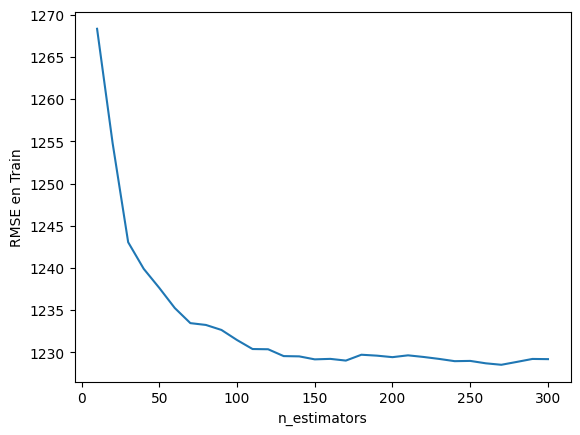

In [11]:
# Celda 5

###################################################   Definición de n_estimators ##########################################################

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar el RMSE promedio para cada valor de n_estimators
rmse_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rfr = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    rmse_scores.append(np.sqrt(-cross_val_score(rfr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')).mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE en Train')

La idea es tener el menor RMSE con el menor número de árboles, para ello se evidencia que n_estimators = 150 con los datos de entrenamiento, a partir de allí parece estabilizarce.

Text(0, 0.5, 'RMSE en Train')

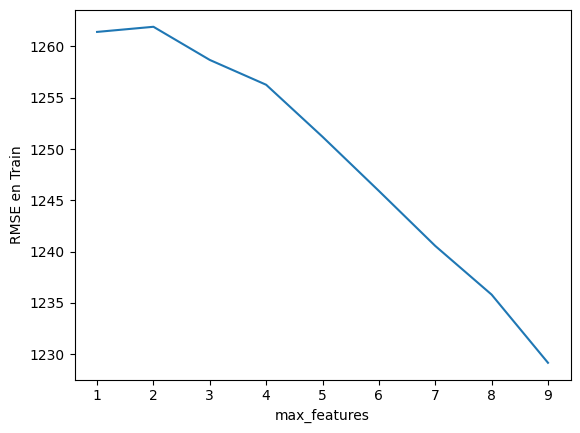

In [12]:
###################################################   Definición de max_features ##########################################################

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_cols = X_train.columns
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
rmse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rfr = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1, n_jobs=-1)
    rmse_scores.append(np.sqrt(-cross_val_score(rfr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')).mean())

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE en Train')


El mejor performance es cuando está alrededor de 9, es decir con todas las variables. Como el max_feature es igual al número de variables que se tiene para el mejor RMSE, se pierde poder predictivo del Random Forest puesto que los árboles que se contruyen internamente ya no tendrían aleatoriedad puesto que serían iguales.

RMSE promedio en el conjunto de entrenamiento por validación cruzada:
1280.7966689720797


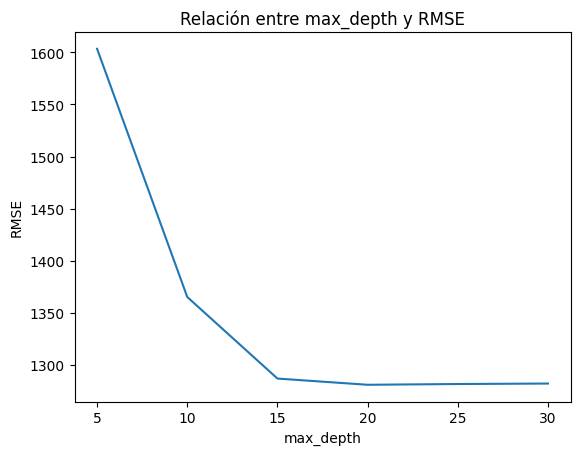

RMSE en el conjunto de prueba:
1813.289185579478


In [13]:
###################################################   Definición de max_depth ##########################################################

# Definir los posibles valores de max_depth a evaluar
max_depth_range = range(0, 35, 5)

# Crear un diccionario con los hiperparámetros a optimizar
param_grid = {'max_depth': max_depth_range}

# Definir el modelo de Random Forest Regressor
rf = RandomForestRegressor(n_estimators=150, random_state=1)

# Realizar la búsqueda grid utilizando validación cruzada de 5 folds y RMSE como métrica de evaluación
grid = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Imprimir los resultados de la búsqueda grid
print("RMSE promedio en el conjunto de entrenamiento por validación cruzada:")
print(sqrt(-grid.best_score_))

# Graficar los valores de max_depth_range vs. RMSE
max_depth_values = []
rmse_values = []

for i in range(len(grid.cv_results_['params'])):
    max_depth_values.append(grid.cv_results_['params'][i]['max_depth'])
    rmse_values.append(sqrt(-grid.cv_results_['mean_test_score'][i]))

plt.plot(max_depth_values, rmse_values)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('Relación entre max_depth y RMSE')
plt.show()

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
y_pred = grid.predict(X_test)
print("RMSE en el conjunto de prueba:")
print(sqrt(mean_squared_error(y_test, y_pred)))


Se observa que el max_depth = 15,  hace el RMSE mínimo y ya no presenta cambios significativos para los siguientes valores. 

In [14]:
# Definición del modelo con los parámetros max_features=9 y n_estimators=150 
rf_f = RandomForestRegressor(n_estimators=150, max_features=9, max_depth=15)
rf_f.fit(X_train, y_train)

# Realizar predicciones con los datos de entrenamiento y testeo
y_pred_train_f = rf_f.predict(X_train)
y_pred_test_f = rf_f.predict(X_test)

# Calcular el MSE, RMSE, MAE y r2 para el set de entrenamiento
mse_train_f = mean_squared_error(y_train, y_pred_train_f)
rmse_train_f = np.sqrt(mse_train_f)
mae_train_f = mean_absolute_error(y_train, y_pred_train_f)
r2_train_f = r2_score(y_train, y_pred_train_f)

# Calcular el MSE, RMSE, MAE y r2 para el set de prueba
mse_test_f = mean_squared_error(y_test, y_pred_test_f)
rmse_test_f = np.sqrt(mse_test_f)
mae_test_f = mean_absolute_error(y_test, y_pred_test_f)
r2_test_f = r2_score(y_test, y_pred_test_f)

# Imprimir los resultados
print('\nResultados en conjunto de train:')
print("MSE:", mse_train_f)
print("RMSE:", rmse_train_f)
print("MAE:", mae_train_f)
print("r2 score:", r2_train_f)

print('\nResultados en conjunto de test:')
print("MSE:", mse_test_f)
print("RMSE:", rmse_test_f)
print("MAE:", mae_test_f)
print("r2 score:", r2_test_f)


Resultados en conjunto de train:
MSE: 481366.7321304794
RMSE: 693.8059758538258
MAE: 480.99535956759166
r2 score: 0.9686235733564542

Resultados en conjunto de test:
MSE: 3044079.3973507225
RMSE: 1744.7290326439584
MAE: 1288.2929576649638
r2 score: 0.8009904299047426


El modelo Random Forest construido con ayuda de la librería sklearn, contemplando los mejores parámetros para su implementación presenta un RMSE de 1744.73 y un MAE de 1288.19 para predecir el precio en el conjunto de Test. Este modelo presenta una mejora importante frente a todos los modelos evaluados hasta este punto como se evidencia en la tabla a continuación, lo que permite resaltar la importancia de encontrar los mejores hiperparámetros para cada modelo.


| Punto  | Modelo                                 | RMSE     | MAE      |
|--------|----------------------------------------|----------|----------|
|    1   | Arbol de regresión manual              | 2609.54  | 2000.83  |
|    2   | Bagging Manual                         | 1796.44  | 1340.01  |
|    3   | Bagging con librería                   | 2698.89  | 2106.93  |
|    4   | Random Forest con librería             | 1840.88  | 1369.84  |
|    5   | Random Forest con librería (optimizado)| 1744.73  | 1288.19  |

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [15]:
# Celda 6

# Se crea la instancia del modelo XGBRegressor
xgb_reg = xgb.XGBRegressor()

# Se ajusta el modelo con los datos de entrenamiento 
xgb_reg.fit(X_train, y_train)

# Realizar predicciones con los datos de entrenamiento y testeo
y_pred_train_xgb = xgb_reg.predict(X_train)
y_pred_test_xgb = xgb_reg.predict(X_test)

# Calcular el MSE, RMSE, MAE y r2 para el set de entrenamiento
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
rmse_train_xgb = np.sqrt(mse_train_xgb)
mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

# Calcular el MSE, RMSE, MAE y r2 para el set de prueba
mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)
rmse_test_xgb = np.sqrt(mse_test_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

# Imprimir los resultados
print('\nResultados en conjunto de train:')
print("MSE:", mse_train_xgb)
print("RMSE:", rmse_train_xgb)
print("MAE:", mae_train_xgb)
print("r2 score:", r2_train_xgb)

print('\nResultados en conjunto de test:')
print("MSE:", mse_test_xgb)
print("RMSE:", rmse_test_xgb)
print("MAE:", mae_test_xgb)
print("r2 score:", r2_test_xgb)


Resultados en conjunto de train:
MSE: 948264.8795126276
RMSE: 973.7889296519178
MAE: 723.0396615490773
r2 score: 0.9381902374121404

Resultados en conjunto de test:
MSE: 2744933.378390514
RMSE: 1656.784046999039
MAE: 1208.7883110486882
r2 score: 0.8205473838661901


El modelo XGBoost de regresión construido con ayuda de la librería XGBoost, contemplando los hiperparámetros por defecto presenta un RMSE de 1656.78 y un MAE de 1208.79 para predecir el precio en el conjunto de Test. Este modelo presenta una mejora importante frente a todos los modelos evaluados hasta este punto como se evidencia en la tabla a continuación, lo que hace evidente la capacidad predictiva de estos modelos incluso mejor de lo que muestra el random forest con sus mejores hiperparámetros.


| Punto  | Modelo                                  | RMSE     | MAE      |
|--------|-----------------------------------------|----------|----------|
|    1   | Arbol de regresión manual               | 2609.54  | 2000.83  |
|    2   | Bagging Manual                          | 1796.44  | 1340.01  |
|    3   | Bagging con librería                    | 2698.89  | 2106.93  |
|    4   | Random Forest con librería (por defecto)| 1840.88  | 1369.84  |
|    5   | Random Forest con librería (optimizado) | 1744.73  | 1288.19  |
|    6   | XGBoost con librería (por defecto)      | 1656.78  | 1208.79  |

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [16]:
# Definimos los posibles valores de los parámetros a calibrar
params = {
    'learning_rate': [0.05, 0.1, 0.15],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 1]
}

# Creamos una instancia del modelo XGBRegressor
reg = xgb.XGBRegressor()

# Aplicamos Grid Search con validación cruzada de 5 pliegues para encontrar la mejor combinación de parámetros
grid_search = GridSearchCV(reg, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

# Imprimimos los valores óptimos de los parámetros y el score del modelo
print("Mejores parámetros: ", grid_search.best_params_)
print("Score: ", grid_search.best_score_)

Mejores parámetros:  {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.15}
Score:  0.876866159647798


* **learning_rate** es la tasa de aprendizaje del modelo. Controla la magnitud de los ajustes que se realizan en los pesos del modelo con cada iteración. Si se establece un valor demasiado bajo, el modelo puede tardar mucho en converger, mientras que un valor demasiado alto puede causar que el modelo no converja en absoluto. En este caso, el valor óptimo encontrado fue de 0.15.

* **gamma** es un parámetro de regularización que controla la complejidad del modelo. A medida que aumenta gamma, se reduce la complejidad del modelo y se evita el sobreajuste. En este caso, el valor óptimo encontrado fue de 0, lo que significa que no se aplicó regularización gamma.

* **colsample_bytree** es el porcentaje de características que se utilizarán para cada árbol. Si se establece un valor demasiado bajo, se pueden perder características importantes y el modelo puede subajustar. Por otro lado, si se establece un valor demasiado alto, el modelo puede sobreajustar. En este caso, el valor óptimo encontrado fue de 1, lo que significa que se utilizaron todas las características para cada árbol lo cual está en coherencia con lo encontrado en el punto 5 donde se pedía optimizar el parámetro 'max_features' y este era igual al número de variables.

El score del modelo encontrado fue de 0.8768, lo que indica un buen desempeño en la tarea de regresión. Con los mejores parámetros para el modelo XGBoost se implementa a continuación:

In [17]:
# Definir los parámetros del modelo
params = {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.15, 'objective': 'reg:squarederror'}

# Instanciar el modelo
xgb_reg_f = xgb.XGBRegressor(**params)

# Entrenar el modelo
xgb_reg_f.fit(X_train, y_train)

# Realizar predicciones con los datos de entrenamiento y testeo
y_pred_train_xgb_f = xgb_reg_f.predict(X_train)
y_pred_test_xgb_f = xgb_reg_f.predict(X_test)

# Calcular el MSE, RMSE, MAE y r2 para el set de entrenamiento
mse_train_xgb_f = mean_squared_error(y_train, y_pred_train_xgb_f)
rmse_train_xgb_f = np.sqrt(mse_train_xgb_f)
mae_train_xgb_f = mean_absolute_error(y_train, y_pred_train_xgb_f)
r2_train_xgb_f = r2_score(y_train, y_pred_train_xgb_f)

# Calcular el MSE, RMSE, MAE y r2 para el set de prueba
mse_test_xgb_f = mean_squared_error(y_test, y_pred_test_xgb_f)
rmse_test_xgb_f = np.sqrt(mse_test_xgb_f)
mae_test_xgb_f = mean_absolute_error(y_test, y_pred_test_xgb_f)
r2_test_xgb_f = r2_score(y_test, y_pred_test_xgb_f)

# Imprimir los resultados
print('\nResultados en conjunto de train:')
print("MSE:", mse_train_xgb_f)
print("RMSE:", rmse_train_xgb_f)
print("MAE:", mae_train_xgb_f)
print("r2 score:", r2_train_xgb_f)

print('\nResultados en conjunto de test:')
print("MSE:", mse_test_xgb_f)
print("RMSE:", rmse_test_xgb_f)
print("MAE:", mae_test_xgb_f)
print("r2 score:", r2_test_xgb_f)


Resultados en conjunto de train:
MSE: 1314088.0850609252
RMSE: 1146.336811352111
MAE: 853.8817584347444
r2 score: 0.914345164191996

Resultados en conjunto de test:
MSE: 2528313.318451748
RMSE: 1590.0670798591323
MAE: 1169.3449246096006
r2 score: 0.8347091251926289


El modelo XGBoost de regresión construido con ayuda de la librería XGBoost, contemplando los mejores hiperparámetros encontrados con la definición de GridSearchCV de la librería Sklearn presenta un RMSE de 1590.07 y un MAE de 1169.34 para predecir el precio en el conjunto de Test. Este modelo presenta el mejor desempeño de todos los modelos evaluados a lo largo del taller. Nuevamente pone en evidencia la capacidad predictiva de estos modelos y lo relevante que es encontrar sus hiperparámetros para potenciarlos aún más.


| Punto  | Modelo                                  | RMSE     | MAE      |
|--------|-----------------------------------------|----------|----------|
|    1   | Arbol de regresión manual               | 2609.54  | 2000.83  |
|    2   | Bagging Manual                          | 1796.44  | 1340.01  |
|    3   | Bagging con librería                    | 2698.89  | 2106.93  |
|    4   | Random Forest con librería (por defecto)| 1840.88  | 1369.84  |
|    5   | Random Forest con librería (optimizado) | 1744.73  | 1288.19  |
|    6   | XGBoost con librería (por defecto)      | 1656.78  | 1208.79  |
|    7   | XGBoost con librería (optimizado)       | 1590.07  | 1169.34  |

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

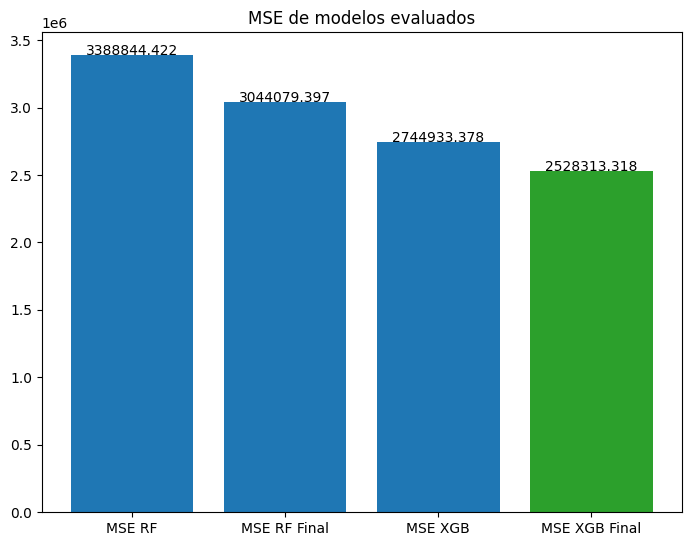

In [18]:
# Celda 8
colors = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:green']

# Gráfica de barras
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("MSE de modelos evaluados")
ejeX = ['MSE RF', 'MSE RF Final', 'MSE XGB', 'MSE XGB Final']
ejeY = [mse_test, mse_test_f, mse_test_xgb, mse_test_xgb_f]
ax.bar(ejeX, ejeY, color=colors)

# Formato etiquetas
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i, y[i]+0.005, str(round(y[i], 3)), ha='center')
addlabels(ejeX, ejeY, plt)

plt.show()

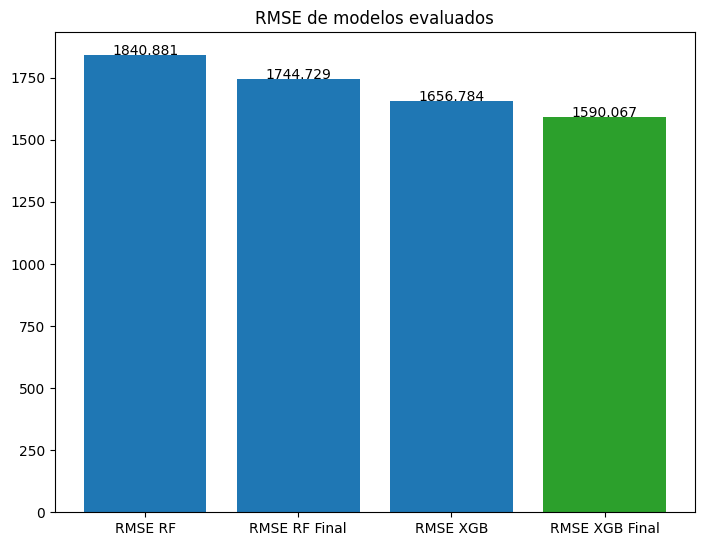

In [19]:
colors = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:green']

# Gráfica de barras
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("RMSE de modelos evaluados")
ejeX = ['RMSE RF', 'RMSE RF Final', 'RMSE XGB', 'RMSE XGB Final']
ejeY = [rmse_test, rmse_test_f, rmse_test_xgb, rmse_test_xgb_f]
ax.bar(ejeX, ejeY, color=colors)

# Formato etiquetas
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i, y[i]+0.005, str(round(y[i], 3)), ha='center')
addlabels(ejeX, ejeY, plt)

plt.show()

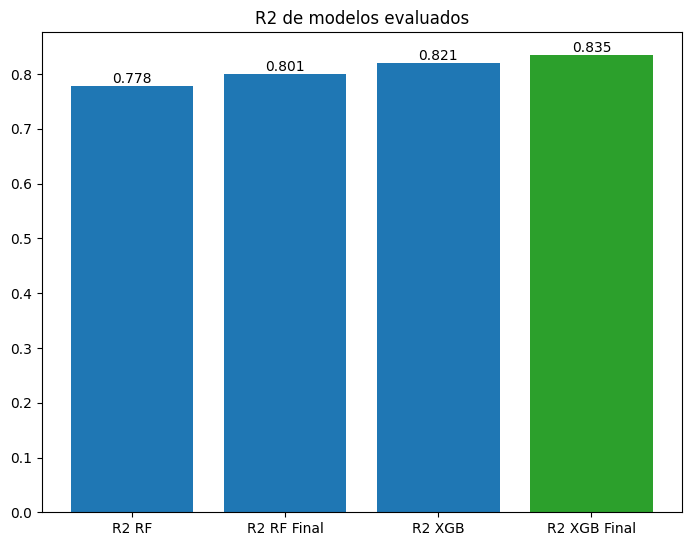

In [20]:
colors = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:green']

# Gráfica de barras
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("R2 de modelos evaluados")
ejeX = ['R2 RF', 'R2 RF Final', 'R2 XGB', 'R2 XGB Final']
ejeY = [r2_test, r2_test_f, r2_test_xgb, r2_test_xgb_f]
ax.bar(ejeX, ejeY, color=colors)

# Formato etiquetas
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i, y[i]+0.005, str(round(y[i], 3)), ha='center')
addlabels(ejeX, ejeY, plt)

plt.show()

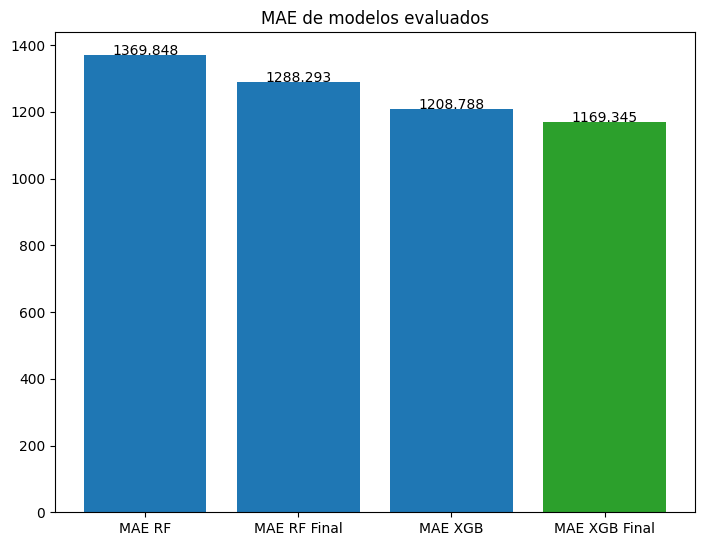

In [21]:
colors = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:green']

# Gráfica de barras
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("MAE de modelos evaluados")
ejeX = ['MAE RF', 'MAE RF Final', 'MAE XGB', 'MAE XGB Final']
ejeY = [mae_test, mae_test_f, mae_test_xgb, mae_test_xgb_f]
ax.bar(ejeX, ejeY, color=colors)

# Formato etiquetas
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i, y[i]+0.005, str(round(y[i], 3)), ha='center')
addlabels(ejeX, ejeY, plt)

plt.show()

En términos generales, tanto Random Forest como XGBoost son técnicas de ensamble que utilizan múltiples árboles de decisión para mejorar la precisión de la predicción en un problema de regresión. Sin embargo, hay algunas diferencias clave entre ambos modelos.

En cuanto a los resultados obtenidos, el modelo de Random Forest optimizado (modelo 5) tiene un RMSE de 1744.73 y un MAE de 1288.19, mientras que el modelo de XGBoost optimizado (modelo 7) tiene un RMSE de 1590.07 y un MAE de 1169.34. El modelo de XGBoost optimizado tiene un mejor rendimiento en ambos indicadores en comparación con el modelo de Random Forest optimizado.

Las ventajas del modelo de XGBoost incluyen:

* Mayor precisión en la predicción en comparación con otros modelos evaluados.
* Funciona bien en conjuntos de datos grandes y complejos, ya que puede manejar una gran cantidad de variables predictoras y tiene una alta capacidad de generalización.
* Puede manejar tanto variables numéricas como categóricas, lo que lo hace más flexible que otros modelos.

Las desventajas del modelo con el menor desempeño, es decir, el modelo de Random Forest con la librería (modelo 4), incluyen:

* No aprovecha al máximo los datos, ya que utiliza el mismo conjunto de datos para entrenar cada árbol de decisión.
* Puede ser propenso al sobreajuste, especialmente si se utilizan muchos árboles de decisión en el modelo.
* No es tan eficiente como otros modelos en términos de tiempo de entrenamiento y predicción, especialmente en conjuntos de datos muy grandes.

En resumen, el modelo de XGBoost optimizado tiene un mejor rendimiento en términos de precisión de predicción y flexibilidad en comparación con el modelo de Random Forest con la librería como se ha ido discutiendo a lo largo del taller. Además, la optimización de hiperparámetros puede mejorar significativamente el rendimiento del modelo. En particular, el modelo de XGBoost optimizado tuvo el mejor desempeño en términos de RMSE, MSE, MAE y R2  como se evidencia en las gráficas presentadas.